In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

In [3]:
plt.style.use('../../../paper_1/figures/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

In [4]:
lgMh_s0_mat = np.load("../../../data/MW-analog/meta_data_psi3/models.npz")["mass"]

lgMh_s15_mat = np.load("../../../data/cross_host/lognorm_015_psi3/models.npz")["mass"]

lgMh_s30_mat = np.load("../../../data/cross_host/lognorm_030_psi3/models.npz")["mass"]

In [5]:
def covariance(mass_2D, min, max, Nbins):

    mass_bins = np.linspace(min, max, Nbins)
    N_ij = np.apply_along_axis(jsm_stats.count, 1, mass_2D, mass_bins) 
    C_ij = np.abs(np.cov(N_ij.T)) # lets just take the absolute value so that the logspace images don't come out all noisy!
    # numerator = np.sum([np.sum(np.diagonal(C_ij, offset=i)) for i in range(1, Nbins)]) # this iterates over the offsets of the diagonal and sums everything!
    # denominator = C_ij.trace()
    # Qstat = numerator/denominator
    return C_ij, mass_bins

#### the covariance in the SHMFs

In [6]:
Mh_min = 9.2
Mh_max = 12.5
Nbins = 26

C_s0, mass_bins = covariance(np.vstack(lgMh_s0_mat), Mh_min, Mh_max, Nbins)

C_s15, _ = covariance(np.vstack(lgMh_s15_mat), Mh_min, Mh_max, Nbins)

C_s30, _ = covariance(np.vstack(lgMh_s30_mat), Mh_min, Mh_max, Nbins)

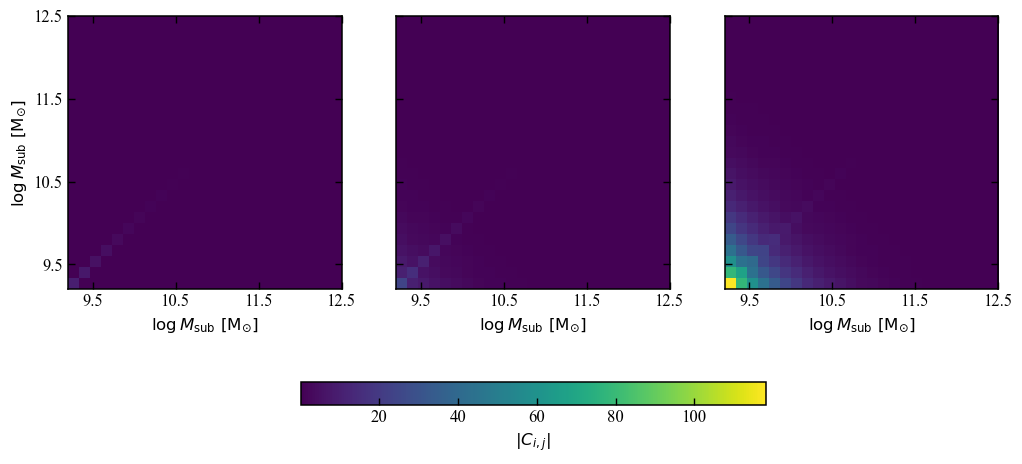

In [7]:
N_max = C_s30.max()
N_min = C_s30.min()

cmap = cm.get_cmap('viridis')
normalizer = Normalize(N_min, N_max)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(C_s0, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max,  origin="lower")
axs[1].imshow(C_s15, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")
axs[2].imshow(C_s30, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([9.5, 10.5, 11.5, 12.5]) 
axs[0].set_yticks([9.5, 10.5, 11.5, 12.5]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("$|C_{i,j}|$")
plt.show()

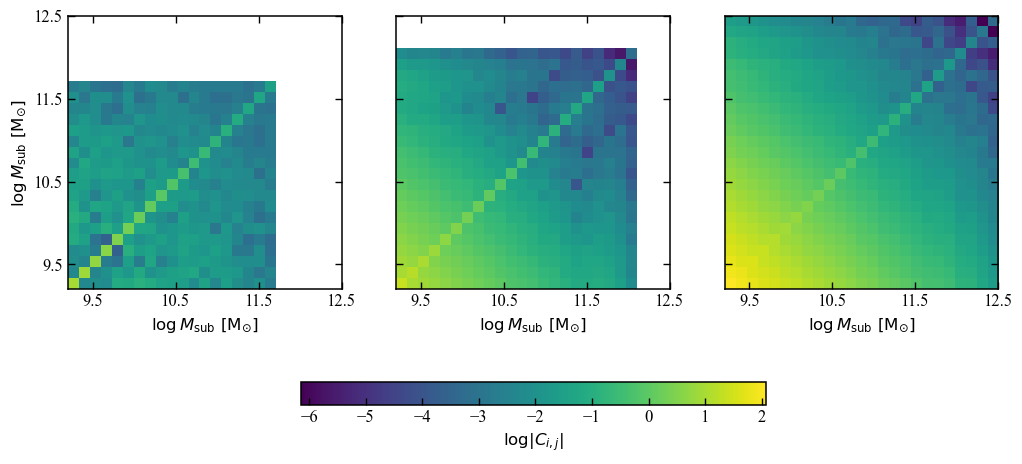

In [8]:
N_max = np.log10(C_s30.max())
N_min = np.log10(C_s30.min())

cmap = cm.get_cmap('viridis')
normalizer = Normalize(N_min, N_max)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(np.log10(C_s0), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max,  origin="lower")
axs[1].imshow(np.log10(C_s15), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")
axs[2].imshow(np.log10(C_s30), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{sub}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([9.5, 10.5, 11.5, 12.5]) 
axs[0].set_yticks([9.5, 10.5, 11.5, 12.5]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("$\log |C_{i,j}|$")
plt.show()

#### now lets convert to stellar mass and look at the covariance in the SMFs

In [9]:
min_mass = 6.5
max_mass = 11.5
theta_fid = [10.5, 2.0, 0.0, 0.0, 0.0, 0.0]

C_s0_mstar, mass_bins = covariance(jsm_SHMR.general_new(theta_fid, np.vstack(lgMh_s0_mat), 0.0, 1.0), min_mass, max_mass, Nbins)

C_s15_mstar, _ = covariance(jsm_SHMR.general_new(theta_fid, np.vstack(lgMh_s15_mat), 0.0, 1.0), min_mass, max_mass, Nbins)

C_s30_mstar, _ = covariance(jsm_SHMR.general_new(theta_fid, np.vstack(lgMh_s30_mat), 0.0, 1.0), min_mass, max_mass, Nbins)

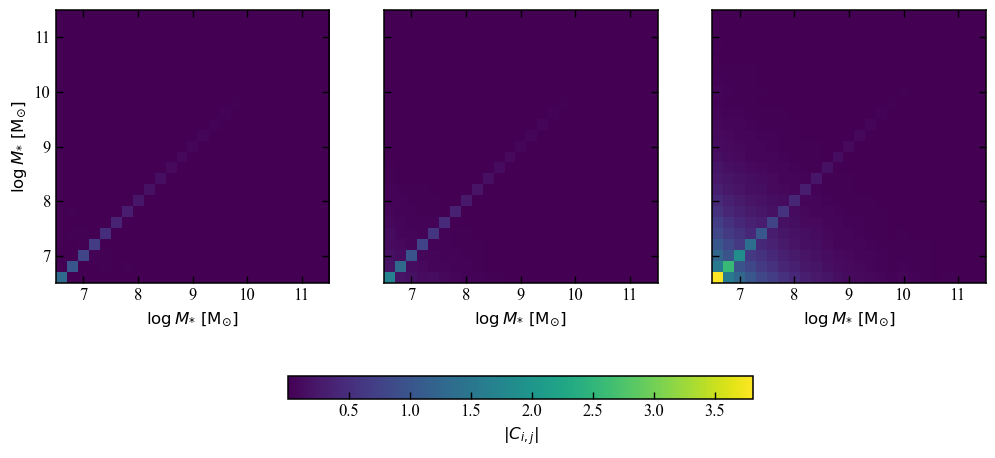

In [10]:
N_max = C_s30_mstar.max()
N_min = C_s30_mstar.min()

cmap = cm.get_cmap('viridis')
normalizer = Normalize(N_min, N_max)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(C_s0_mstar, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max,  origin="lower")
axs[1].imshow(C_s15_mstar, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")
axs[2].imshow(C_s30_mstar, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([7, 8, 9, 10, 11]) 
axs[0].set_yticks([7, 8, 9, 10, 11]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("$|C_{i,j}|$")
plt.show()

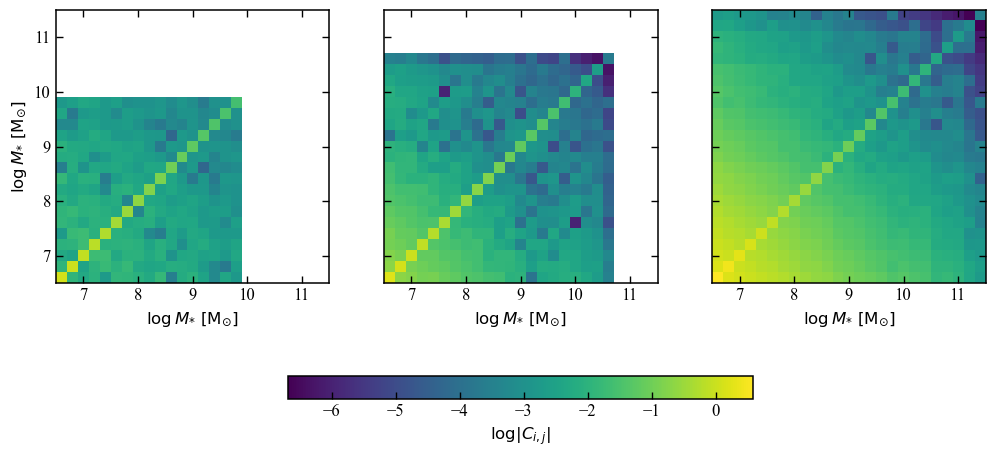

In [11]:
N_max = np.log10(C_s30_mstar.max())
N_min = np.log10(C_s30_mstar.min())

cmap = cm.get_cmap('viridis')
normalizer = Normalize(N_min, N_max)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(np.log10(C_s0_mstar), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max,  origin="lower")
axs[1].imshow(np.log10(C_s15_mstar), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")
axs[2].imshow(np.log10(C_s30_mstar), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([7, 8, 9, 10, 11]) 
axs[0].set_yticks([7, 8, 9, 10, 11]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("$\log |C_{i,j}|$")
plt.show()

#### finally, the covariance in the stacked SMF

In [12]:
def NADLER_cov(lgMh_mat, theta=theta_fid):

    lgMs_mat = np.apply_along_axis(jsm_SHMR.general_new, 0, theta, lgMh_mat, 0.0, 1.0)
    N_ij = np.zeros(shape=(lgMh_mat.shape[0], Nbins-1))

    for ind, realization in enumerate(lgMs_mat):
        stat_i = jsm_stats.SatStats_D_NADLER(realization, min_mass, max_mass, Nbins)
        N_ij[ind] = stat_i.stack
    C_ij = np.abs(np.cov(N_ij.T))
    return C_ij, N_ij

In [13]:
C_s0_stacked, test_0 = NADLER_cov(lgMh_s0_mat)

C_s15_stacked, test_15 = NADLER_cov(lgMh_s15_mat)

C_s30_stacked, test_30 = NADLER_cov(lgMh_s30_mat)

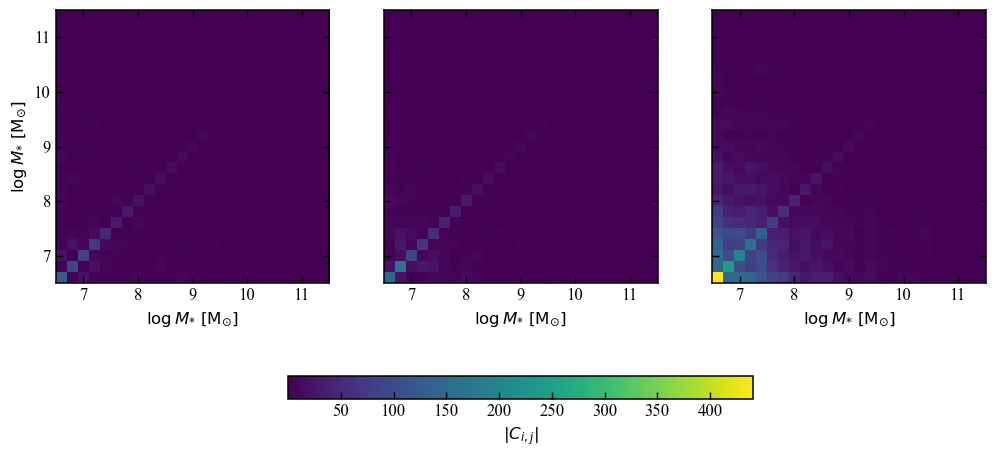

In [14]:
N_max = C_s30_stacked.max()
N_min = C_s30_stacked.min()

cmap = cm.get_cmap('viridis')
normalizer = Normalize(N_min, N_max)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(C_s0_stacked, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max,  origin="lower")
axs[1].imshow(C_s15_stacked, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")
axs[2].imshow(C_s30_stacked, extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([7, 8, 9, 10, 11]) 
axs[0].set_yticks([7, 8, 9, 10, 11]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("$|C_{i,j}|$")
plt.show()

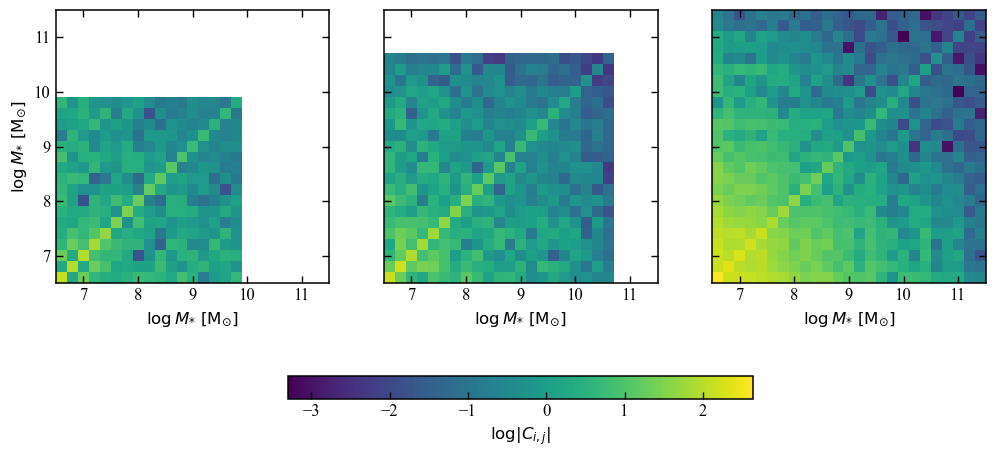

In [15]:
N_max = np.log10(C_s30_stacked.max())
N_min = np.log10(C_s30_stacked.min())

cmap = cm.get_cmap('viridis')
normalizer = Normalize(N_min, N_max)
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, axs=plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(12, 8))

axs[0].imshow(np.log10(C_s0_stacked), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max,  origin="lower")
axs[1].imshow(np.log10(C_s15_stacked), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")
axs[2].imshow(np.log10(C_s30_stacked), extent=[mass_bins.min(), mass_bins.max(), mass_bins.min(), mass_bins.max()], cmap=cmap, vmin=N_min, vmax=N_max, origin="lower")

axs[0].set_aspect(1/axs[0].get_data_ratio(), adjustable="box")
axs[1].set_aspect(1/axs[1].get_data_ratio(), adjustable="box")
axs[2].set_aspect(1/axs[2].get_data_ratio(), adjustable="box")

axs[0].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_ylabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[1].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[2].set_xlabel("$\log M_{\mathrm{*}}\ [\mathrm{M}_{\odot}]$")
axs[0].set_xticks([7, 8, 9, 10, 11]) 
axs[0].set_yticks([7, 8, 9, 10, 11]) 

cm_test = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", shrink=0.5)
cm_test.set_label("$\log |C_{i,j}|$")
plt.show()